# Building a Spam Filter Using Naive Bayes

## 1. Exploring the Dataset

In this project, we will build a spam filter for SMS messages using the Multinomial Naive Bayes algorithm. Our goal is to write a program that classifies new messages with an accuracy greater than `80%`, meaning that more than `80%` of the new messages will be correctly classified as either spam or ham (non-spam).

To train the algorithm, we'll use a dataset of `5,572` SMS messages that have been manually classified. The dataset was compiled by `Tiago A. Almeida` and `José María Gómez Hidalgo`, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).

To get started, we'll import the necessary libraries and load the dataset.

In [1]:
# Import the relevant libraries
import pandas as pd
import re

# Load the SMS spam dataset, using tab as the separator and specifying column names
sms_df = pd.read_csv('Datasets/sms_spam_collection', sep='\t', header=None, names=['Label', 'SMS'])

# Print the shape of the dataset and display the first few rows
print(sms_df.shape)
sms_df.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The two columns of the dataset represent the label (`spam` or `ham`) and the actual message content. The messages vary in length and tone, with `ham` being the most common class in the first five rows.

In [2]:
# Calculate the proportion of each label in the dataset
sms_df['Label'].value_counts(normalize=True)

Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

We see that about `86.59%` of the messages are classified as ham, while the remaining `13.41%` are classified as spam. Since most messages people receive in real life are non-spam, this sample appears to be representative.

## 2. Creating Training and Test Sets

When developing software like a spam filter, a good rule of thumb is to design the test before creating the software. If we write the software first, there's a temptation to create a biased test to ensure the software passes. To evaluate how well our spam filter classifies new messages, we'll split our dataset into two parts.

We will keep `80%` of our dataset for training and `20%` for testing. Our goal is to train the algorithm on as much data as possible while still retaining enough data for testing. With `5,572` messages in total, this means the training set will contain `4,458` messages, while the test set will contain `1,114` messages.

When the spam filter is ready, we will treat all `1,114` messages in our test set as new and have the filter classify them. Once we obtain the results, we can compare the algorithm's classifications with the human-assigned labels, allowing us to evaluate how effective the spam filter truly is.

In [3]:
# Randomize the dataset to ensure proper distribution of spam and ham
sms_df_randomized = sms_df.sample(frac=1, random_state=42)

# Calculate the index that separates the training and test sets
split_index = round(len(sms_df_randomized) * 0.8)

# Split the randomized data into a training set (80%) and a test set (20%)
training_set = sms_df_randomized[:split_index].reset_index(drop=True)
test_set = sms_df_randomized[split_index:].reset_index(drop=True)

# Print the shapes of the training and test sets
print(training_set.shape)
print(test_set.shape)

# Display the proportion of each label in the training and test sets
display(training_set['Label'].value_counts(normalize=True))
display(test_set['Label'].value_counts(normalize=True))

(4458, 2)
(1114, 2)


Label
ham     0.866981
spam    0.133019
Name: proportion, dtype: float64

Label
ham     0.861759
spam    0.138241
Name: proportion, dtype: float64

We observe that the percentages of spam and ham messages in both the training and test sets closely match those in the full dataset, where approximately `87%` of the messages are ham and the remaining `13%` are spam.

## 3. Cleaning the Data

### 3.1. Explaining the Naive Bayes Algorithm

When a new message comes in, our Multinomial Naive Bayes algorithm will classify it based on the results from these two equations:
\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
\end{equation}

\begin{equation}
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}

To calculate **P(w$_i$|Spam)** and **P(w$_i$|Ham)** in the formulas above, we will use the following equations:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

Here's a summary of the terms in the equations above:

\begin{aligned}
&N_{w_i|Spam} = \text{the number of times the word } w_i \text{ occurs in spam messages.} \\
&N_{w_i|Ham} = \text{the number of times the word } w_i \text{ occurs in non-spam messages.} \\
&N_{Spam} = \text{total number of words in spam messages.} \\
&N_{Ham} = \text{total number of words in non-spam messages.} \\
&N_{Vocabulary} = \text{total number of words in the vocabulary.} \\
&\alpha = 1 \ \ \ (\alpha \text{ is the smoothing parameter}).
\end{aligned}

To calculate the probabilities, we first need to clean the data to put it into a format that allows us to easily extract the necessary information. Our goal is to transform the data as shown in the following table:

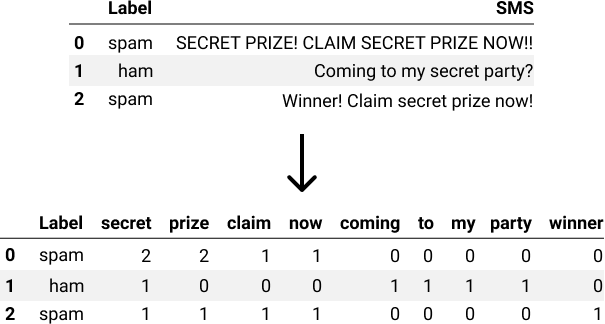

Regarding this transformation, we observe that:
- The `SMS` column no longer exists. Instead, it has been replaced by a series of new columns, where each column represents a unique word from the vocabulary.
- Each row describes a single message. For example, the first row corresponds to the message: `SECRET PRIZE! CLAIM SECRET PRIZE NOW!!`, and it has the values: `spam`, `2`, `2`, `1`, `1`, `0`, `0`, `0`, `0`, `0`. These values indicate that:
    - The message is classified as spam.
    - The words `claim` and `now` each occur once in the message.
    - The words `secret` and `prize` each occur twice in the message.
    - The words `coming`, `to`, `my`, `party`, and `winner` do not appear in the message.
- All words in the vocabulary are in lowercase, so `SECRET` and `secret` are considered the same word.
- Punctuation is no longer taken into account. For instance, we can't deduce from the table that the first message originally contained three exclamation marks.

### 3.2. Removing Punctuation and Converting Text to Lowercase

Let's start the data cleaning process by removing punctuation and converting all words to lowercase in the training data.

In [4]:
# Display the first 5 rows of the training set before any changes
training_set.head()

,Label,SMS
0,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
1,ham,And also I've sorta blown him off a couple tim...
2,ham,Mmm thats better now i got a roast down me! i...
3,ham,Mm have some kanji dont eat anything heavy ok
4,ham,So there's a ring that comes with the guys cos...


In [5]:
# Remove punctuation and replace it with spaces, then convert all text to lowercase
training_set['SMS'] = training_set['SMS'].str.replace(r"\W", " ", regex=True)
training_set['SMS'] = training_set['SMS'].str.lower()

# Display the first 5 rows of the training set after the changes
training_set.head()

,Label,SMS
0,ham,squeeeeeze this is christmas hug if u lik ...
1,ham,and also i ve sorta blown him off a couple tim...
2,ham,mmm thats better now i got a roast down me i ...
3,ham,mm have some kanji dont eat anything heavy ok
4,ham,so there s a ring that comes with the guys cos...


As we can see, words like `Squeeeeeze!!` are now `squeeeeeze`, and contractions such as `I've` have been split into `i ve`. This ensures consistency for further analysis, though splitting contractions and removing punctuation could slightly alter the original meaning of some texts.

### 3.3. Creating the Vocabulary

With the exception of the `Label` column, every other new column after performing our data transformation should represent a unique word in our vocabulary. More specifically, each column should indicate the frequency of that unique word for any given message. Note that we refer to the set of unique words as the vocabulary.

Now, let's create a list of all the unique words that occur in the messages of our training set.

In [6]:
# Split the 'SMS' column into lists of words for each message
training_set['SMS'] = training_set['SMS'].str.split()
vocabulary = []

# Iterate through each message and add each word to the vocabulary list
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
# Convert the vocabulary to a set and display the total number of unique words in the vocabulary
vocabulary = list(set(vocabulary))
len(vocabulary)

7816

As we can see, there are `7,816` unique words in all the messages of our training set.

### 3.4. Updating the Training Set

We will now use the vocabulary to perform the desired transformation. To do this, we'll first initialize a dictionary where each key is a unique word from the vocabulary list, and each value will be a list of zeros with the same length as the number of rows in the `SMS` column.

After counting the occurrences of each word in every message and updating the word counts dictionary, we'll convert it into a DataFrame.

In [7]:
# Create a dictionary to hold counts of each unique word for each message in the training set
word_counts = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

# Iterate through each message, counting occurrences of each word and updating the dictionary
for i, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts[word][i] += 1

# Convert the word counts dictionary into a DataFrame and display the first few rows
word_counts = pd.DataFrame(word_counts)
word_counts.head()

,ticket,hopeso,sorting,chest,chiong,click,paying,aiyar,spjanuary,cheer,...,billy,tihs,mint,aaooooright,nightnight,slippers,blood,oz,close,77
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The word counts DataFrame contains `7,816` columns, with each column representing a unique word from the vocabulary and the values indicating the frequency of each word in the corresponding SMS messages. Next, we're going to concatenate the word counts DataFrame with the original training set to include word frequency data.

In [8]:
# Concatenate the word counts DataFrame with the original training set
training_set = pd.concat([training_set, word_counts], axis=1)
training_set.head(3)

,Label,SMS,ticket,hopeso,sorting,chest,chiong,click,paying,aiyar,...,billy,tihs,mint,aaooooright,nightnight,slippers,blood,oz,close,77
0,ham,"[squeeeeeze, this, is, christmas, hug, if, u, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[and, also, i, ve, sorta, blown, him, off, a, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[mmm, thats, better, now, i, got, a, roast, do...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The updated training set consists of `7,818` columns, with the first two columns representing the label and the processed SMS message as a list of words. The additional columns reflect the frequency of `7,816` unique words from the vocabulary in each message. Entries that remain `0` indicate the absence of those words in the messages.

## 4. Calculating Constants and Parameters

Now that we have completed our training set, we can begin creating the spam filter. To start, let's calculate **P(Spam)**, **P(Ham)**, **N<sub>Vocabulary</sub>**, **N<sub>Spam</sub>**, and **N<sub>Ham</sub>**. We will also use **Laplace smoothing** and set `α = 1`.

In [9]:
# Calculate the number of unique words and set the smoothing parameter (α)
n_vocabulary = len(vocabulary)
alpha = 1

# Separate the training set into spam and ham messages
spams = training_set[training_set['Label'] == 'spam']
hams = training_set[training_set['Label'] == 'ham']

# Calculate the probabilities of spam and ham
p_spam = len(spams) / len(training_set)
p_ham = len(hams) / len(training_set)

# Count the total number of words in spam messages
n_words_per_spam = spams['SMS'].apply(len)
n_spam = n_words_per_spam.sum()

# Count the total number of words in ham messages
n_words_per_ham = hams['SMS'].apply(len)
n_ham = n_words_per_ham.sum()

The terms **P(Spam)**, **P(Ham)**, **N<sub>Vocabulary</sub>**, **N<sub>Spam</sub>**, **N<sub>Ham</sub>** will have constant values in our equations for every new message, regardless of the individual words in it. However, **P(w$_i$|Spam)** and **P(w$_i$|Ham)** will vary depending on the individual words. For instance, **P("secret"|Spam)** will have a specific probability value, while **P("cousin"|Spam)** or **P("lovely"|Spam)** will most likely have different values.

Although both **P(w$_i$|Spam)** and **P(w$_i$|Ham)** vary depending on the word, the probability for each individual word is constant for every new message. For instance, let's say we receive two new messages: `secret code` and `secret party 2night`. We'll need to calculate **P("secret"|Spam)** for both messages, and we can use the training set to obtain the values we need to find a result for the following equation:
\begin{equation}
P(\text{"secret"}|Spam) = \frac{N_{"secret"|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

The steps we take to calculate **P("secret"|Spam)** will be identical for both of our new messages above, or for any other new message that contains the word `secret`. The key detail here is that calculating **P("secret"|Spam)** only depends on the training set, and as long as we don't make changes to the training set, **P("secret"|Spam)** stays constant. The same reasoning also applies to **P("secret"|Ham)**.

This means we can use our training set to calculate the probability for each word in our vocabulary. For instance, if our vocabulary contained only the words `lost`, `navigate`, and `sea`, we'd need to calculate six probabilities:
- **P("lost"|Spam)** and **P("lost"|Ham)**
- **P("navigate"|Spam)** and **P("navigate"|Ham)**
- **P("sea"|Spam)** and **P("sea"|Ham)**

Since we have `7,783` words in our vocabulary, we'll need to calculate a total of `15,566` probabilities. For each word, we need to calculate both **P(w$_i$|Spam)** and **P(w$_i$|Ham)**. In more technical terms, these probability values are referred to as **parameters**.

The fact that we calculate so many values before even starting the classification of new messages makes the Naive Bayes algorithm very fast, especially compared to other algorithms. When a new message comes in, most of the necessary computations are already done, allowing the algorithm to classify the message almost instantly.

If we don’t calculate all these values beforehand, the algorithm will need to perform these calculations every time a new message comes in. Imagine the algorithm is used to classify `1,000,000` new messages; why repeat the same calculations a million times when we could simply do them once at the start?

In [10]:
# Initialize dictionaries to store probabilities for each word in spam and ham messages
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}

# Loop through each word in the vocabulary
for word in vocabulary:
    
    # Calculate the probability of the word given it's in a spam message
    n_word_given_spam = spams[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    # Calculate the probability of the word given it's in a ham message
    n_word_given_ham = hams[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## 5. Building and Testing the Spam Filter

Now that we've calculated all the necessary constants and parameters, we can begin building the spam filter. This filter functions as follows:

- It takes a new message **(w1, w2, ..., wn)** as input.
- It calculates **P(Spam|w1, w2, ..., wn)** and **P(Ham|w1, w2, ..., wn)**.
- It compares these values and:
    - If **P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn)**, the message is classified as ham.
    - If **P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn)**, the message is classified as spam.
    - If **P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn)**, the algorithm flags the message for human review.
    
Note that some new messages may include words that aren't part of the vocabulary. However, we can safely ignore these words when calculating the probabilities.

In [11]:
# Define the spam filter function
def spam_filter(message):

    # Remove punctuation, convert to lowercase, and split the message into words
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    # Initialize probabilities using prior values
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    # Calculate probabilities based on message content
    for word in message:
        
        # Multiply by the word's probability given it's spam
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        # Multiply by the word's probability given it's ham
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    # Display the calculated probabilities
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    # Classify the message based on the probabilities
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('The probabilities are equal! Please ask a person to classify this.')

Next, let's test the `spam_filter` function using two examples.

In [12]:
# Call the function with a sample message
spam_filter('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.5223001843661562e-25
P(Ham|message): 1.2176099861344542e-27
Label: Spam


In [13]:
# Call the function with a sample message
spam_filter("Sounds good, Tom, then see u there")

P(Spam|message): 4.74693224259436e-25
P(Ham|message): 2.7878169823581606e-21
Label: Ham


## 6. Measuring the Spam Filter's Accuracy

Finally, we've successfully created a spam filter and classified two new messages. Now, we'll test how well the spam filter performs on our test set of `1,114` messages.

The algorithm will output a classification label for each message in our test set, which we'll then compare to the actual label provided by a human. Since the algorithm hasn't seen these `1,114` messages during training, each message in the test set is essentially new from the algorithm's perspective.

To begin, let's apply a slightly modified version of the `spam_filter` function to each SMS message in the `SMS` column of the test set.

In [14]:
# Define the modified spam filter function
def spam_filter_modified(message):

    # Remove punctuation, convert to lowercase, and split the message into words
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    # Initialize probabilities using prior values
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    # Calculate probabilities based on message content
    for word in message:
        
        # Multiply by the word's probability given it's spam
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        # Multiply by the word's probability given it's ham
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    # Classify the message based on the probabilities
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'The probabilities are equal! Please ask a person to classify this.'

# Apply the modified spam filter to the test set and store the predicted labels
test_set['Predicted'] = test_set['SMS'].apply(spam_filter_modified)
test_set.head()

,Label,SMS,Predicted
0,ham,Was playng 9 doors game and gt racing on phone...,ham
1,ham,I dont thnk its a wrong calling between us,ham
2,ham,All e best 4 ur exam later.,ham
3,ham,Hey what how about your project. Started aha da.,ham
4,ham,"Dunno, my dad said he coming home 2 bring us o...",ham


The model correctly predicts all the messages in the first five rows of the test set as `ham`, matching the true labels. However, further analysis is needed for overall test accuracy.

We'll compare the predicted values with the actual values to assess how well our spam filter classifies new messages. To evaluate this, we will use accuracy as our metric:

\begin{equation}
\text{Accuracy} = \frac{\text{Number of correctly classified messages}}{\text{Total number of classified messages}}
\end{equation}

In [15]:
# Initialize counters for correct predictions and total number of messages
correct = 0
total = test_set.shape[0]

# Iterate through each row in the test set
for row in test_set.iterrows():
    
    # Access the actual row data, and check if the predicted label matches the actual label
    row = row[1]
    if row['Label'] == row['Predicted']:
        correct += 1

# Print the number of correct and incorrect classifications, as well as the accuracy
print("Correct classifications:", correct)
print("Incorrect classifications:", total - correct)
print("Filter's accuracy:", correct / total)

Correct classifications: 1092
Incorrect classifications: 22
Filter's accuracy: 0.9802513464991023


The spam filter correctly classified `1,092` out of `1,114` messages, resulting in an accuracy of `98.02%`. Only `22` messages were misclassified.

## 7. Conclusion

In this project, we built a spam filter for SMS messages using the Multinomial Naive Bayes algorithm. The dataset, containing `5,572` manually classified SMS messages, was sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection). Initially, the dataset had two columns: the label (`spam` or `ham`) and the message content. Approximately `86.59%` of the messages were labeled as ham, and `13.41%` as spam. This reflects a realistic distribution, as most real-world messages are non-spam.

To assess the performance of our spam filter on new messages, we split the dataset into `80%` for training and `20%` for testing. Out of `5,572` messages, the training set contains `4,458` messages, and the test set includes `1,114`. Moreover, the percentage of spam and ham messages in both sets mirrors the overall dataset, with about `87%` of the messages labeled as ham and `13%` as spam.

After explaining the Multinomial Naive Bayes classification algorithm in detail, we cleaned the training data by removing punctuation and converting all words to lowercase. The data cleaning process ensured consistency for analysis, though splitting contractions and removing punctuation may have slightly altered the original meaning of some messages.

After updating the training set, it now contains `7,818` columns. The first two columns represent the label and the processed SMS message as a list of words, while the additional columns show the frequency of `7,816` unique words from the vocabulary for each message. Entries with a value of `0` indicate that those words are absent in the respective messages.

After calculating all the necessary constants and parameters, we proceeded to build the spam filter and tested it on two sample messages. We then evaluated its performance on our test set of `1,114` messages. The algorithm classified each message, and we compared its predictions to the actual human-provided labels. Since the algorithm hadn't encountered these messages during training, each was essentially new.

The spam filter correctly classified `1,092` out of `1,114` messages, achieving an accuracy of `98.02%`, with only `22` misclassified messages.